In [1]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models # redundant ish import -- resolve later
from scipy import fft

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[]
2.16.1


In [8]:
df = pd.read_csv('../codes.csv') # reads in codes csv as a mutable df :-) contains message, ecl, code, dft cols

In [18]:
df['code'][1007]

'1111111011111010101010111111110000010101000110001001000001101110101000000010011010111011011101001001111111110101110110111010010100100001001011101100000101100010000101010000011111111010101010101010111111100000000110011100000100000000001110101000000010111111001110110000101111001110000001101100110110000110000110110111100101000010001011011100000110111000001010101011010000000010010010001011100011000100111101001101100000001011000011110001100100101010101010011100100100100010011001110100001011001111100001011011011101101010011010001010100001001100000101010101100100110111101110101010100100101001101000111111110100000000011110001001110001101111111110001110011011101010000100000100100100101101000110001011101010111101111011111100010111010100110100001100011000101110101110101010100001100101000001001111000111101011001011111110011110011110000010000'

In [9]:
# parse a colomn with a 2d array of each qr code
df['code_array'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x]).reshape(29, 29))
df['code_oned'] = df['code'].apply(lambda x: np.array([int(digit) for digit in x])) # adds a code_oned column to our df which parses our entries from strs to ints

In [10]:
arrays = np.stack(df['code_array'].values)
average_array = np.mean(arrays, axis=0)

fixedIndx = []
for i in range(29):
    for j in range(29):
        if average_array[i][j] == 1:
            fixedIndx.append((i, j))

fixedIndxAll = []
for i in range(29):
    for j in range(29):
        if average_array[i][j] == 1 or average_array[i][j] == 0:
            fixedIndxAll.append((i, j))





In [11]:
nonFixed = []
for i in range(29):
    for j in range(29):
        if (i,j) not in fixedIndxAll:
            nonFixed.append((i,j))
nonFixed

[(0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 16),
 (0, 17),
 (0, 19),
 (0, 20),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (4, 19),
 (4, 20),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (5, 19),
 (5, 20),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (7, 17),
 (7, 18),
 (7, 19),
 (7, 20),
 (8, 2),
 (8, 3),
 (8, 4),
 (8, 5),
 (8, 7),
 (8, 8),
 (8, 9),
 (8, 10),
 (8, 11),
 (8, 12),
 (8, 13),
 (8, 14),
 

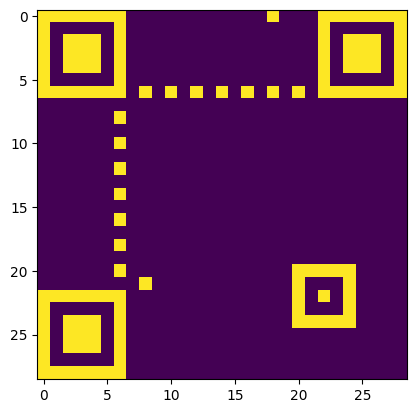

In [12]:
fixedQR = np.zeros((29,29))
for i,j in fixedIndx:
    fixedQR[i][j] = 1
fixedQR

plt.imshow(fixedQR)

In [13]:
np.sum(fixedQR.flatten())

132.0

In [14]:
fixed_fft = fft.fft2(fixedQR)

In [ ]:
fixed_fft

In [16]:
# grabs a centered subarray of a given array with dimensions (2L+1) by (2L+1)
def get_centered_subarray(array, L):
    # old way -- 
    # L = (L * 2) + 1
    # start = center - (L // 2)
    # end = center + (L + 1) // 2
    n = array.shape[0]
    center = n // 2
    start = center - L
    end = center + 1 + L # start count after our center square
    # Adjust indices to stay within array bounds
    start = max(0, start)
    end = min(n, end)
    return array[start:end, start:end]

In [17]:
# function to split DFT into real and imaginary parts and reshape them
def split_dft(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    imag_part = np.array([c.imag for c in complex_numbers])
    return real_part, imag_part

# apply the function to each row
df['dft_real'], df['dft_imag'] = zip(*df['dft'].apply(split_dft))


In [28]:
# function to take dft string into complex tuple stored as (a, ib)
def combine_dft_full(dft_str):
    complex_numbers = [complex(c.strip()) for c in dft_str.strip('()').split(')(')]
    real_part = np.array([c.real for c in complex_numbers])
    # real_part = zero_pad_right(0.5, real_part)
    imag_part = np.array([c.imag for c in complex_numbers])
    # imag_part = zero_pad_right(0.5, imag_part)
    return np.append(real_part, imag_part)

df['dft_stacked'] = df['dft'].apply(combine_dft_full)

In [29]:
flat = fixed_fft.copy().flatten() # flatten fixed 

# subtracts flattened fixed qr fft from flattened qr fft
def adjust(stacked):
    copy = stacked.copy()
    for i in range(841): 
        copy[i] -= flat[i].real
        copy[i+841] -= flat[i].imag # imaginary numbers shifted by 841 (total len)
    return copy

df['adjusted'] = df['dft_stacked'].apply(adjust)

In [ ]:
print(flat)
print(df['dft_stacked'][1])
df['adjusted'][1]

In [30]:
def adjust_y(flat):
    new = np.array([flat[row * 29 + column] for row, column in nonFixed])
    return new

df['y_adjusted'] = df['code_oned'].apply(adjust_y)


In [31]:
# Features (X) - DFT components
X = np.stack(df['adjusted'].values)  # Shape: (num_samples, 1682) - (flat) total input data

# Labels (y) - QR codes
y = np.stack(df['y_adjusted'].values)  # Shape: (num_samples, 841) - (flat)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # decide on a rseed of 42 and a set set of 20%

In [63]:
# initializes our model :-)
def init_model(L):
    model = tf.keras.Sequential()
    
    # Add the input layer (implicitly defined by the first layer)
    model.add(tf.keras.layers.InputLayer(input_shape=((((L*2)+1)**2)*2,))) # shape is twice the size of our L box, one for real part and one for imaginary
    
    #optional hidden layer
    # model.add(tf.keras.layers.Dense(500))
    # Add the output layer with Y units (no activation for regression, 'softmax' or 'sigmoid' for classification)
    model.add(tf.keras.layers.Dense(592))
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    # Compile the model (use appropriate loss and metrics for your task)
    model.compile(optimizer=optimizer, loss='mse')  # or 'categorical_crossentropy' for classification
    return model

In [33]:
def evaluate_model(model, X_test, y_test, num_samples=5):
    """
    evaluates the trained model on the test set and displays a few samples with their predictions.

    parameters:
    - model: The trained TensorFlow/Keras model.
    - X_test: The input features for the test set (shape: (num_samples, 1682)).
    - y_test: The true labels for the test set (shape: (num_samples, 841)).
    - num_samples: The number of test samples to display.

    returns:
    - accuracy: The overall accuracy of the model on the test set.
    """
    # make predictions on the test set
    predictions = model.predict(X_test)
    
    # binarize the predictions (0 or 1)
    predictions_binarized = (predictions > 0.5).astype(np.int32)
    
    # calculate accuracy
    correct_predictions = np.sum(predictions_binarized == y_test)
    total_elements = y_test.size
    accuracy = correct_predictions / total_elements
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # displays some predictions!
    # for i in range(num_samples):
    #     plt.figure(figsize=(12, 4))

    #     # original QR code
    #     plt.subplot(1, 3, 1)
    #     plt.title("Original QR Code")
    #     plt.imshow(y_test[i].reshape(29, 29), cmap='gray')
    #     plt.axis('off')

    #     # predicted QR code
    #     plt.subplot(1, 3, 2)
    #     plt.title("Predicted QR Code")
    #     plt.imshow(predictions_binarized[i].reshape(29, 29), cmap='gray')
    #     plt.axis('off')

    #     # difference (Error)
    #     plt.subplot(1, 3, 3)
    #     plt.title("Difference (Error)")
    #     plt.imshow(y_test[i].reshape(29, 29) - predictions_binarized[i].reshape(29, 29), cmap='gray')
    #     plt.axis('off')

    #     plt.show()
        
    return accuracy

# # example usage:
# accuracy = evaluate_model(model, X_test[:999], y_test[:999], num_samples=5)


In [96]:
# # rolls it to be correctly centered
# df['dft_imag_rolled'] = df['dft_imag'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))
# df['dft_real_rolled'] = df['dft_real'].apply(lambda x: np.roll(x.reshape(29,29), shift=(14, 14), axis=(0, 1)))

# # df['dft_imag_rolled'][0].shape # ensures our roll was successfull

In [35]:
df['dft_rolled'] = df['adjusted'].apply(lambda x: np.roll(x.reshape(29,29,2), shift=(14, 14), axis=(0, 1)))

In [ ]:
L = 10
stat = []
for L in range(10,0,-1):
    # # adds L cols to df, one for real/imag component
    # df['L_imag'] = df['dft_imag_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
    # df['L_real']= df['dft_real_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
    # concats real and imag components into a single col
    df['L'] = df['dft_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
    # df['L'] = df.apply(lambda row: np.concatenate((row['L_real'], row['L_imag'])), axis=1)
    model = init_model(L) # inits our model
    
    # features (X) - DFT components
    X = np.stack(df['L'].values)  # shape: (num_samples, ((L*2)+1)*2) - due to dims of L box * 2 for real and imag
    # split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # calculate and append (L, accuracy)
    model.fit(X_train, y_train, epochs=25, validation_data=[X_test[7000:], y_test[7000:]])
    accuracy = evaluate_model(model, X_test[:6999], y_test[:6999], num_samples=1)
    stat.append((L, accuracy))

    print(stat)

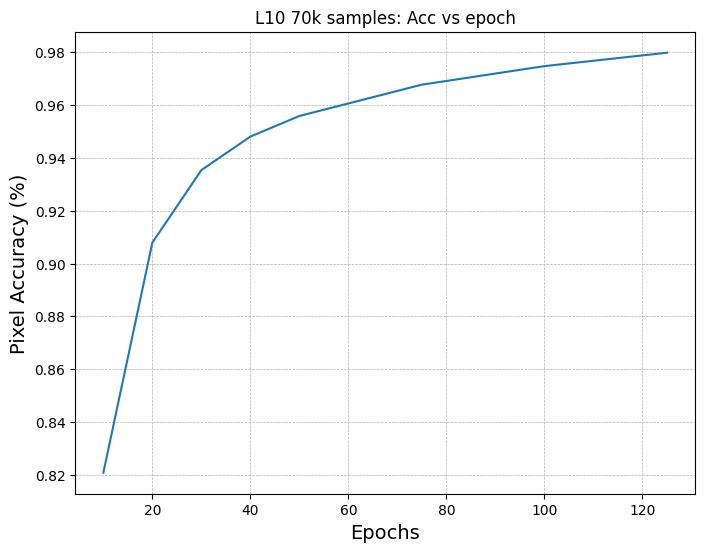

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlabel('Epochs', fontsize=14)
ax.set_ylabel('Pixel Accuracy (%)', fontsize=14)
ax.set_title('L10 70k samples: Acc vs epoch')
ax.plot([st[0] for st in stat], [st[1] for st in stat]) # plots accuracy vs L -- we can add labels later!


In [59]:
fig.savefig('L10_epoch_accuracy_70k.png', dpi=300)

In [60]:
stat

[(10, 0.820744244529511),
 (20, 0.9079110280129089),
 (30, 0.9353905594109356),
 (40, 0.9480948603205657),
 (50, 0.9559003200264956),
 (75, 0.9677708575631773),
 (100, 0.9747909333528456),
 (125, 0.9798681286729876)]

In [65]:
# Set L to 10 and initialize stat to store accuracy at specified epoch intervals
L = 5
stat = []

df['L'] = df['dft_rolled'].apply(lambda x: get_centered_subarray(x, L).flatten())
# df['L'] = df.apply(lambda row: np.concatenate((row['L_real'], row['L_imag'])), axis=1)
model = init_model(L) # inits our model

# features (X) - DFT components
X = np.stack(df['L'].values)  # shape: (num_samples, ((L*2)+1)*2) - due to dims of L box * 2 for real and imag
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify epoch intervals to record accuracy
epoch_intervals = [10, 20, 30, 40, 50, 75, 100, 125, 150,175, 200]
current_epoch = 0

# Training in intervals and recording accuracy
for epochs in epoch_intervals:
    # Train the model from the current epoch to the next interval
    
    model.fit(X_train, y_train, initial_epoch=current_epoch, epochs=epochs, validation_data=(X_test[1000:], y_test[1000:]))
    current_epoch = epochs  # Update the current epoch to the last trained epoch

    # Evaluate the model and record accuracy
    accuracy = evaluate_model(model, X_test[7000:], y_test[7000:])
    stat.append((epochs, accuracy))

    # Print or log the current status
    print(f"Epochs: {epochs}, Accuracy: {accuracy}")

print("Final stat:", stat)

Epoch 1/10
1753/1753 [==============================] - 14s 7ms/step - loss: 23.0158 - val_loss: 13.9787
Epoch 2/10
1753/1753 [==============================] - 11s 6ms/step - loss: 9.6976 - val_loss: 6.7138
Epoch 3/10
1753/1753 [==============================] - 11s 6ms/step - loss: 4.9170 - val_loss: 3.6520
Epoch 4/10
1753/1753 [==============================] - 10s 5ms/step - loss: 2.8081 - val_loss: 2.2088
Epoch 5/10
1753/1753 [==============================] - 10s 6ms/step - loss: 1.7757 - val_loss: 1.4697
Epoch 6/10
1753/1753 [==============================] - 10s 5ms/step - loss: 1.2214 - val_loss: 1.0531
Epoch 7/10
1753/1753 [==============================] - 9s 5ms/step - loss: 0.8994 - val_loss: 0.7973
Epoch 8/10
1753/1753 [==============================] - 9s 5ms/step - loss: 0.6990 - val_loss: 0.6358
Epoch 9/10
1753/1753 [==============================] - 9s 5ms/step - loss: 0.5673 - val_loss: 0.5227
Epoch 10/10
220/220 [==============================] - 1s 3ms/step
Test Ac